In [1]:
import os

from datetime import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

from mpl_toolkits.axes_grid1 import host_subplot
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

[2022-11-05 22:23:11.444 MacBook-Pro-2.local:73378 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


##  Configure SageMaker environment

In [2]:
# set SageMaker role
os.environ['AWS_PROFILE']='sagemaker'
os.environ['AWS_DEFAULT_REGION']='eu-central-1'

In [3]:
session = sagemaker.Session()
bucket = session.default_bucket()
print(bucket)
prefix = "sagemaker/ml-capistone-project"
role = sagemaker.get_execution_role()

sagemaker-eu-central-1-292065287762


## Prepare data

In [4]:
# Load data
stock_list = ['NFLX', 'EPAM', 'AAPL']

end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

for stock in stock_list:
    globals()[stock] = yf.download(stock, start, end)

stock_data = [NFLX, EPAM, AAPL]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# set data
stock_df = EPAM
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-06,99.669998,100.279999,98.040001,99.949997,99.949997,332800
2017-11-07,99.949997,101.550003,98.839996,100.730003,100.730003,465800
2017-11-08,100.419998,103.440002,100.160004,102.989998,102.989998,349800
2017-11-09,102.019997,103.250000,101.529999,102.339996,102.339996,233100
2017-11-10,101.779999,103.489998,101.720001,102.800003,102.800003,163200


In [6]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-11-06 to 2022-11-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


In [7]:
# save data
data_folder='data'
os.makedirs(data_folder, exist_ok=True)  
stock_df.to_csv(data_folder + '/stock.csv') 

In [32]:
# upload stock data to S3
inputs = session.upload_data(path=data_folder, bucket=bucket, key_prefix=prefix)
print("S3 path: {}".format(inputs))

S3 path: s3://sagemaker-eu-central-1-292065287762/sagemaker/ml-capistone-project


## Hyperparameter tunner

### Find best CPU otimized instance for training

In [23]:
spot_use_instances = True
spot_max_wait=2500
spot_max_run=2500
hyperparameters = {
    'epochs': 600,
    'learning_rate': 0.0001,
    'feature_columns': '"Adj Close"' # for multiple values use: '"Adj Close" "Volume"'
}

In [24]:
# Optimal instances for current paylad.
# CPU instantce ml.c5.2xlarge
# GPU instance ml.g4dn.xlarge -> best instance
estimator = PyTorch(
    entry_point='hpo.py',
    source_dir='src',
    base_job_name='stock-predictor',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    framework_version='1.12',
    py_version='py38',
    hyperparameters=hyperparameters,
    use_spot_instances=spot_use_instances,
    max_wait=spot_max_wait,
    max_run=spot_max_run
)

In [25]:
estimator.fit({'data': inputs}, wait=True)

2022-10-19 07:04:42 Starting - Starting the training job...
2022-10-19 07:05:10 Starting - Preparing the instances for trainingProfilerReport-1666163081: InProgress
.........
2022-10-19 07:06:37 Downloading - Downloading input data
2022-10-19 07:06:37 Training - Downloading the training image...............................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-10-19 07:11:57,197 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-10-19 07:11:57,226 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-10-19 07:11:57,232 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-10-19 07:11:57,826 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "data": "/opt/ml/input/data/data"
    },
    "current_host"

### Find best hyperparameters

In [28]:
spot_use_instances = True
spot_max_wait=2500
spot_max_run=2500
hyperparameters = {
    'epochs': 600,
    'feature_columns': '"Adj Close"', # for multiple values use: '"Adj Close" "Volume"'
    'use_mask': True,
    'learning_rate': 0.0001
}

In [29]:
estimator = PyTorch(
    entry_point='hpo.py',
    source_dir='src',
    base_job_name='stock-predictor',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    framework_version='1.12',
    py_version='py38',
    hyperparameters=hyperparameters,
    use_spot_instances=spot_use_instances,
    max_wait=spot_max_wait,
    max_run=spot_max_run
)

In [30]:
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Train loss: ([0-9\\.]+)"}]

In [31]:
# 0.0001 is best descovered learning rate
# use_mask = False perform better
hyperparameter_ranges = {
    'learning_rate': ContinuousParameter(0.00005, 0.005),
    'use_mask': CategoricalParameter([True, False])
}

In [32]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=12,
    max_parallel_jobs=3,
    objective_type=objective_type
)

In [33]:
tuner.fit({'data': inputs}, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


## Stock estimator

In [9]:
# best training job parameters
# default learning rate: 0.0001
learning_rate = 0.0000634
use_mask = True

In [53]:
# estimator configuration
instance_type = 'ml.g4dn.xlarge' # default 'ml.g4dn.xlarge'
spot_use_instances = True
spot_max_wait=10000
spot_max_run=10000

In [11]:
hyperparameters = {
    'epochs': 50, # 200 # 2000
    'learning_rate': learning_rate,
    'use_mask': True,
    'feature_columns': '"Adj Close"' # for multiple values use: '"Adj Close" "Volume"'
}
hyperparameters

{'epochs': 50,
 'learning_rate': 6.34e-05,
 'use_mask': True,
 'feature_columns': '"Adj Close"'}

In [12]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [13]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

In [75]:
estimator = PyTorch(
    entry_point='hpo.py',
    source_dir='src',
    base_job_name='stock-predictor',
    role=role,
    instance_count=1,
    instance_type=instance_type,
    framework_version='1.12',
    py_version='py38',
    hyperparameters=hyperparameters,
    # ## Spot instances
    # use_spot_instances=spot_use_instances,
    # max_wait=spot_max_wait,
    # max_run=spot_max_run,
    # ## Debugger and Profiler parameters
    # rules = rules,
    # debugger_hook_config=hook_config,
    # profiler_config=profiler_config,
)

In [76]:
estimator.fit({'data': inputs}, wait=True)

2022-11-06 17:42:23 Starting - Starting the training job...
2022-11-06 17:42:48 Starting - Preparing the instances for trainingProfilerReport-1667756536: InProgress
......
2022-11-06 17:43:54 Downloading - Downloading input data...
2022-11-06 17:44:09 Training - Downloading the training image..............................
2022-11-06 17:49:30 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-11-06 17:49:19,403 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-11-06 17:49:19,434 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-11-06 17:49:19,440 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-11-06 17:49:19,880 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -

In [77]:
model=estimator.model_data
model

's3://sagemaker-eu-central-1-292065287762/stock-predictor-2022-11-06-17-42-15-676/output/model.tar.gz'

In [17]:
training_job_name = estimator.latest_training_job.name
print(f"Training job name: {training_job_name}")

Training job name: stock-predictor-2022-11-05-21-24-02-579


In [19]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

In [64]:
trial.tensor_names()

[2022-10-19 22:05:27.342 MacBook-Pro-2.local:89118 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2022-10-19 22:05:28.396 MacBook-Pro-2.local:89118 INFO trial.py:210] Loaded all steps


['MSELoss_output_0',
 'gradient/TransformerTime2Vec_decoder.bias',
 'gradient/TransformerTime2Vec_decoder.weight',
 'gradient/TransformerTime2Vec_embedding.bias',
 'gradient/TransformerTime2Vec_embedding.weight',
 'gradient/TransformerTime2Vec_time2vecEncoder.bias_linear',
 'gradient/TransformerTime2Vec_time2vecEncoder.bias_periodic',
 'gradient/TransformerTime2Vec_time2vecEncoder.weights_linear',
 'gradient/TransformerTime2Vec_time2vecEncoder.weights_periodic',
 'gradient/TransformerTime2Vec_transformer_encoder.layers.0.linear1.bias',
 'gradient/TransformerTime2Vec_transformer_encoder.layers.0.linear1.weight',
 'gradient/TransformerTime2Vec_transformer_encoder.layers.0.linear2.bias',
 'gradient/TransformerTime2Vec_transformer_encoder.layers.0.linear2.weight',
 'gradient/TransformerTime2Vec_transformer_encoder.layers.0.norm1.bias',
 'gradient/TransformerTime2Vec_transformer_encoder.layers.0.norm1.weight',
 'gradient/TransformerTime2Vec_transformer_encoder.layers.0.norm2.bias',
 'gradie

In [72]:
print(len(trial.tensor("MSELoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("MSELoss_output_0").steps(mode=ModeKeys.EVAL)))
print(len(trial.tensor("MSELoss_output_0").steps(mode=ModeKeys.PREDICT)))

6600
800
0


In [90]:
def get_data(trial, tname, mode, sampling=10):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)[::sampling]
    vals = []
    for s in tqdm(steps):
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [91]:
def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

100%|██████████| 660/660 [35:16<00:00,  3.21s/it]  


loaded TRAIN data


100%|██████████| 80/80 [05:29<00:00,  4.12s/it]


loaded EVAL data
completed TRAIN plot
completed EVAL plot


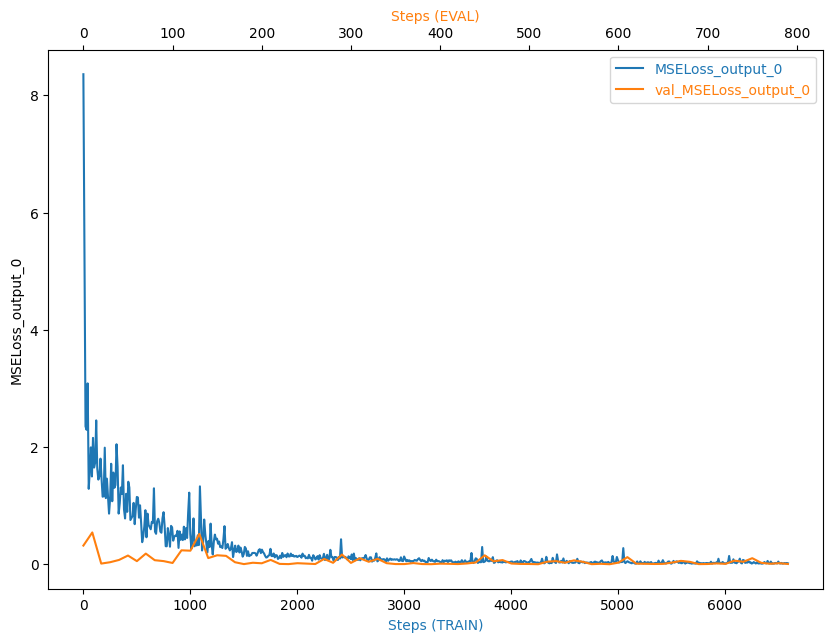

In [92]:
plot_tensor(trial, "MSELoss_output_0")

In [94]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
region = session.boto_region_name
training_job = TrainingJob(training_job_name, region)
training_job.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-eu-central-1-292065287762/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}}
s3 path:s3://sagemaker-eu-central-1-292065287762/stock-predictor-2022-10-19-19-48-25-448/profiler-output


Profiler data from system is available


In [95]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = training_job.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-10-20 23:39:11.317 MacBook-Pro-2.local:89118 INFO metrics_reader_base.py:134] Getting 13 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1'}


In [96]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-eu-central-1-292065287762/stock-predictor-2022-10-19-19-48-25-448/rule-output


In [97]:
! aws s3 ls {rule_output_path} --recursive

2022-10-19 22:02:27     374217 stock-predictor-2022-10-19-19-48-25-448/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-10-19 22:02:27     230388 stock-predictor-2022-10-19-19-48-25-448/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-10-19 22:02:22        192 stock-predictor-2022-10-19-19-48-25-448/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-10-19 22:02:22       8591 stock-predictor-2022-10-19-19-48-25-448/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-10-19 22:02:22       2294 stock-predictor-2022-10-19-19-48-25-448/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-10-19 22:02:22        130 stock-predictor-2022-10-19-19-48-25-448/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-10-19 22:02:22       5227 stock-predictor-2022-10-19-19-48-25-448/rule-output/ProfilerReport/profiler-output/profiler-reports/I

In [98]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-eu-central-1-292065287762/stock-predictor-2022-10-19-19-48-25-448/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-eu-central-1-292065287762/stock-predictor-2022-10-19-19-48-25-448/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-eu-central-1-292065287762/stock-predictor-2022-10-19-19-48-25-448/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-eu-central-1-292065287762/stock-predictor-2022-10-19-19-48-25-448/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-eu-central-1-292065287762/stock

In [99]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [100]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [48]:
from sagemaker.serverless import ServerlessInferenceConfig

serverless_config = ServerlessInferenceConfig(
	memory_size_in_mb=6144, # max amount of memory
	max_concurrency=1
)
endpoint_name = "stock-predictor-serverless-16"

In [128]:
# # deploy model from source
# model = estimator.create_model(entry_point="hpo.py", source_dir="src")

# # Deploy the model to a ml.m4.xlarge instance
# predictor = model.deploy(
#     serverless_inference_config=serverless_config
# )

-----!

In [130]:
# inputs = [546, 578, 590]
# predicted_classes = predictor.predict(inputs)
# print(predicted_classes)

In [ ]:
# # deploy estimator from training job
# attached_estimator = Estimator.attach(training_job_name)
# attached_estimator.logs()
# attached_estimator.deploy(
#   endpoint_name = endpoint_name, 
# 	entry_point="hpo.py",
# 	serverless_inference_config=serverless_config
# )

In [57]:
estimator.logs()
predictor_server = estimator.deploy(
	endpoint_name = "stock-predictor-serverless-server", 
	entry_point="inference.py", # default "hpo.py"
	instance_type=instance_type,
    initial_instance_count=1
)

2022-11-06 10:09:38 Starting - Preparing the instances for training
2022-11-06 10:09:38 Downloading - Downloading input data
2022-11-06 10:09:38 Training - Training image download completed. Training in progress.
2022-11-06 10:09:38 Uploading - Uploading generated training model
2022-11-06 10:09:38 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-11-06 10:07:11,268 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-11-06 10:07:11,296 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-11-06 10:07:11,302 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-11-06 10:07:11,766 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requirements.txt
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 20.8

In [58]:
stock_input = [[[10], [24], [56], [55], [23], [45], [77]]]
predicted_classes = predictor_server.predict(stock_input)
print(predicted_classes)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://eu-central-1.console.aws.amazon.com/cloudwatch/home?region=eu-central-1#logEventViewer:group=/aws/sagemaker/Endpoints/stock-predictor-serverless-server in account 292065287762 for more information.

In [79]:
# serverless config
estimator.logs()
predictor = estimator.deploy(
	endpoint_name = endpoint_name, 
	entry_point="inference.py", # default "hpo.py"
	serverless_inference_config=serverless_config
)

2022-11-06 17:51:10 Starting - Preparing the instances for training
2022-11-06 17:51:10 Downloading - Downloading input data
2022-11-06 17:51:10 Training - Training image download completed. Training in progress.
2022-11-06 17:51:10 Uploading - Uploading generated training model
2022-11-06 17:51:10 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-11-06 17:49:19,403 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-11-06 17:49:19,434 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-11-06 17:49:19,440 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-11-06 17:49:19,880 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requirements.txt
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 22.0

In [80]:
stock_input = [[[10], [24], [56], [55], [23], [45], [77]]]
predicted_classes = predictor.predict(stock_input)
print(predicted_classes)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from model with message "'utf-8' codec can't decode byte 0x93 in position 0: invalid start byte
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/sagemaker_inference/transformer.py", line 142, in transform
    result = self._run_handler_function(
  File "/opt/conda/lib/python3.8/site-packages/sagemaker_inference/transformer.py", line 276, in _run_handler_function
    result = func(*argv_context)
  File "/opt/conda/lib/python3.8/site-packages/sagemaker_inference/transformer.py", line 259, in _default_transform_fn
    data = self._run_handler_function(self._input_fn, *(input_data, content_type))
  File "/opt/conda/lib/python3.8/site-packages/sagemaker_inference/transformer.py", line 276, in _run_handler_function
    result = func(*argv_context)
  File "/opt/ml/model/code/inference.py", line 82, in input_fn
    data = json.loads(request_body)
  File "/opt/conda/lib/python3.8/json/__init__.py", line 343, in loads
    s = s.decode(detect_encoding(s), 'surrogatepass')
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x93 in position 0: invalid start byte
". See https://eu-central-1.console.aws.amazon.com/cloudwatch/home?region=eu-central-1#logEventViewer:group=/aws/sagemaker/Endpoints/stock-predictor-serverless-16 in account 292065287762 for more information.

In [81]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONLinesSerializer
from sagemaker.deserializers import JSONLinesDeserializer

predictor = Predictor(
    endpoint_name=endpoint_name,
    serializer=JSONLinesSerializer(),
    deserializer=JSONLinesDeserializer(),
    sagemaker_session=session
)

# inputs = [546, 578, 590]
stock_input = "[[[10], [24], [56], [55], [23], [45], [77]]]"

predicted_classes = predictor.predict(stock_input)

print(predicted_classes)

# for predicted_class in predicted_classes:
#     print("Predicted class {} with probability {}".format(predicted_class['predicted_label'], predicted_class['probability']

[[[192.57860718498978]]]


In [117]:
# predictor.delete_endpoint()